In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [8]:
# 📦 Setup
import os
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from PIL import Image
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
from sklearn.model_selection import train_test_split  # ✅ Fixed import


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [9]:
# ========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unlabeled_root = "/kaggle/input/leafdetection7/Niphad Grape Leaf Disease Dataset (NGLD) (2)/unlabel"

augment = T.Compose([
    T.RandomResizedCrop(224),
    T.RandomHorizontalFlip(),
    T.ColorJitter(0.5, 0.5, 0.5, 0.1),
    T.RandomGrayscale(p=0.2),
    T.ToTensor(),
    T.Normalize([0.5]*3, [0.5]*3)
])

fine_tune_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize([0.5]*3, [0.5]*3)
])

# ========================
# Unlabeled Dataset
# ========================
class UnlabeledImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, f) 
                            for f in os.listdir(root_dir) 
                            if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

class BYOLPairDataset(Dataset):
    def __init__(self, base_dataset, augment_fn):
        self.base_dataset = base_dataset
        self.augment_fn = augment_fn

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        image = self.base_dataset[idx]
        return self.augment_fn(image), self.augment_fn(image)

In [10]:
# BYOL Model
# ========================
class MLPHead(nn.Module):
    def __init__(self, in_dim, hidden_dim=4096, out_dim=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim)
        )

    def forward(self, x):
        return self.net(x)

class BYOL(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.online_encoder = nn.Sequential(backbone, MLPHead(2048))
        self.target_encoder = nn.Sequential(backbone, MLPHead(2048))
        self.predictor = MLPHead(256, 4096, 256)
        for param_q, param_k in zip(self.online_encoder.parameters(), self.target_encoder.parameters()):
            param_k.data.copy_(param_q.data)
            param_k.requires_grad = False

    def update_target(self, beta=0.99):
        for param_q, param_k in zip(self.online_encoder.parameters(), self.target_encoder.parameters()):
            param_k.data = beta * param_k.data + (1 - beta) * param_q.data

    def forward(self, x1, x2):
        q1 = self.predictor(self.online_encoder(x1))
        q2 = self.predictor(self.online_encoder(x2))
        with torch.no_grad():
            k1 = self.target_encoder(x2)
            k2 = self.target_encoder(x1)
        return q1, k1.detach(), q2, k2.detach()

def byol_loss(x, y):
    x = nn.functional.normalize(x, dim=-1)
    y = nn.functional.normalize(y, dim=-1)
    return 2 - 2 * (x * y).sum(dim=-1).mean()


In [11]:
# Prepare BYOL dataset and dataloader
base_unlabeled_dataset = UnlabeledImageDataset(unlabeled_root)
byol_dataset = BYOLPairDataset(base_unlabeled_dataset, augment_fn=augment)
byol_loader = DataLoader(byol_dataset, batch_size=64, shuffle=True)

# Initialize BYOL model
resnet = models.resnet50(pretrained=False)
resnet.fc = nn.Identity()
byol_model = BYOL(resnet).to(device)
optimizer = torch.optim.Adam(byol_model.parameters(), lr=3e-4)

# Training configuration
num_epochs = 50  # set to 1 for testing
train_losses = []

# Pretraining loop
for epoch in range(num_epochs):
    byol_model.train()
    total_loss = 0

    for x1, x2 in tqdm(byol_loader, desc=f"Pretraining Epoch {epoch+1}"):
        x1, x2 = x1.to(device), x2.to(device)
        q1, k1, q2, k2 = byol_model(x1, x2)

        loss = byol_loss(q1, k1) + byol_loss(q2, k2)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        byol_model.update_target()

        total_loss += loss.item()

    avg_loss = total_loss / len(byol_loader)
    train_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {avg_loss:.4f}")


Pretraining Epoch 1: 100%|██████████| 43/43 [01:34<00:00,  2.21s/it]


Epoch [1/50] Loss: 1.8340


Pretraining Epoch 2: 100%|██████████| 43/43 [01:16<00:00,  1.77s/it]


Epoch [2/50] Loss: 1.4552


Pretraining Epoch 3: 100%|██████████| 43/43 [01:16<00:00,  1.78s/it]


Epoch [3/50] Loss: 1.1824


Pretraining Epoch 4: 100%|██████████| 43/43 [01:16<00:00,  1.78s/it]


Epoch [4/50] Loss: 1.0063


Pretraining Epoch 5: 100%|██████████| 43/43 [01:15<00:00,  1.77s/it]


Epoch [5/50] Loss: 0.9014


Pretraining Epoch 6: 100%|██████████| 43/43 [01:16<00:00,  1.79s/it]


Epoch [6/50] Loss: 0.8534


Pretraining Epoch 7: 100%|██████████| 43/43 [01:16<00:00,  1.77s/it]


Epoch [7/50] Loss: 0.8109


Pretraining Epoch 8: 100%|██████████| 43/43 [01:16<00:00,  1.77s/it]


Epoch [8/50] Loss: 0.7557


Pretraining Epoch 9: 100%|██████████| 43/43 [01:16<00:00,  1.77s/it]


Epoch [9/50] Loss: 0.7381


Pretraining Epoch 10: 100%|██████████| 43/43 [01:16<00:00,  1.77s/it]


Epoch [10/50] Loss: 0.7121


Pretraining Epoch 11: 100%|██████████| 43/43 [01:16<00:00,  1.77s/it]


Epoch [11/50] Loss: 0.6902


Pretraining Epoch 12: 100%|██████████| 43/43 [01:16<00:00,  1.78s/it]


Epoch [12/50] Loss: 0.6288


Pretraining Epoch 13: 100%|██████████| 43/43 [01:16<00:00,  1.78s/it]


Epoch [13/50] Loss: 0.5587


Pretraining Epoch 14: 100%|██████████| 43/43 [01:16<00:00,  1.78s/it]


Epoch [14/50] Loss: 0.5090


Pretraining Epoch 15: 100%|██████████| 43/43 [01:16<00:00,  1.77s/it]


Epoch [15/50] Loss: 0.4594


Pretraining Epoch 16: 100%|██████████| 43/43 [01:16<00:00,  1.78s/it]


Epoch [16/50] Loss: 0.3977


Pretraining Epoch 17: 100%|██████████| 43/43 [01:16<00:00,  1.77s/it]


Epoch [17/50] Loss: 0.3595


Pretraining Epoch 18: 100%|██████████| 43/43 [01:16<00:00,  1.77s/it]


Epoch [18/50] Loss: 0.3690


Pretraining Epoch 19: 100%|██████████| 43/43 [01:16<00:00,  1.78s/it]


Epoch [19/50] Loss: 0.3671


Pretraining Epoch 20: 100%|██████████| 43/43 [01:16<00:00,  1.77s/it]


Epoch [20/50] Loss: 0.3590


Pretraining Epoch 21: 100%|██████████| 43/43 [01:16<00:00,  1.77s/it]


Epoch [21/50] Loss: 0.3261


Pretraining Epoch 22: 100%|██████████| 43/43 [01:16<00:00,  1.77s/it]


Epoch [22/50] Loss: 0.3564


Pretraining Epoch 23: 100%|██████████| 43/43 [01:15<00:00,  1.77s/it]


Epoch [23/50] Loss: 0.3890


Pretraining Epoch 24: 100%|██████████| 43/43 [01:15<00:00,  1.77s/it]


Epoch [24/50] Loss: 0.4125


Pretraining Epoch 25: 100%|██████████| 43/43 [01:16<00:00,  1.77s/it]


Epoch [25/50] Loss: 0.4324


Pretraining Epoch 26: 100%|██████████| 43/43 [01:16<00:00,  1.78s/it]


Epoch [26/50] Loss: 0.5024


Pretraining Epoch 27: 100%|██████████| 43/43 [01:16<00:00,  1.77s/it]


Epoch [27/50] Loss: 0.5409


Pretraining Epoch 28: 100%|██████████| 43/43 [01:15<00:00,  1.75s/it]


Epoch [28/50] Loss: 0.6065


Pretraining Epoch 29: 100%|██████████| 43/43 [01:15<00:00,  1.76s/it]


Epoch [29/50] Loss: 0.6659


Pretraining Epoch 30: 100%|██████████| 43/43 [01:15<00:00,  1.76s/it]


Epoch [30/50] Loss: 0.7210


Pretraining Epoch 31: 100%|██████████| 43/43 [01:15<00:00,  1.75s/it]


Epoch [31/50] Loss: 0.7533


Pretraining Epoch 32: 100%|██████████| 43/43 [01:16<00:00,  1.77s/it]


Epoch [32/50] Loss: 0.8086


Pretraining Epoch 33: 100%|██████████| 43/43 [01:16<00:00,  1.78s/it]


Epoch [33/50] Loss: 0.8302


Pretraining Epoch 34: 100%|██████████| 43/43 [01:16<00:00,  1.77s/it]


Epoch [34/50] Loss: 0.9048


Pretraining Epoch 35: 100%|██████████| 43/43 [01:16<00:00,  1.77s/it]


Epoch [35/50] Loss: 0.9392


Pretraining Epoch 36: 100%|██████████| 43/43 [01:16<00:00,  1.78s/it]


Epoch [36/50] Loss: 0.9401


Pretraining Epoch 37: 100%|██████████| 43/43 [01:15<00:00,  1.76s/it]


Epoch [37/50] Loss: 0.9144


Pretraining Epoch 38: 100%|██████████| 43/43 [01:15<00:00,  1.76s/it]


Epoch [38/50] Loss: 0.9227


Pretraining Epoch 39: 100%|██████████| 43/43 [01:16<00:00,  1.77s/it]


Epoch [39/50] Loss: 0.9002


Pretraining Epoch 40: 100%|██████████| 43/43 [01:16<00:00,  1.78s/it]


Epoch [40/50] Loss: 0.8487


Pretraining Epoch 41: 100%|██████████| 43/43 [01:16<00:00,  1.78s/it]


Epoch [41/50] Loss: 0.8301


Pretraining Epoch 42: 100%|██████████| 43/43 [01:16<00:00,  1.78s/it]


Epoch [42/50] Loss: 0.8126


Pretraining Epoch 43: 100%|██████████| 43/43 [01:15<00:00,  1.77s/it]


Epoch [43/50] Loss: 0.7791


Pretraining Epoch 44: 100%|██████████| 43/43 [01:16<00:00,  1.79s/it]


Epoch [44/50] Loss: 0.7921


Pretraining Epoch 45: 100%|██████████| 43/43 [01:16<00:00,  1.77s/it]


Epoch [45/50] Loss: 0.8062


Pretraining Epoch 46: 100%|██████████| 43/43 [01:16<00:00,  1.78s/it]


Epoch [46/50] Loss: 0.7781


Pretraining Epoch 47: 100%|██████████| 43/43 [01:16<00:00,  1.78s/it]


Epoch [47/50] Loss: 0.8122


Pretraining Epoch 48: 100%|██████████| 43/43 [01:16<00:00,  1.78s/it]


Epoch [48/50] Loss: 0.8294


Pretraining Epoch 49: 100%|██████████| 43/43 [01:16<00:00,  1.78s/it]


Epoch [49/50] Loss: 0.8320


Pretraining Epoch 50: 100%|██████████| 43/43 [01:16<00:00,  1.78s/it]

Epoch [50/50] Loss: 0.9057


In [12]:

torch.save(byol_model.online_encoder[0].state_dict(), "byol_encoder.pth")
print("✅ BYOL pretrained encoder saved as 'byol_encoder.pth'")


✅ BYOL pretrained encoder saved as 'byol_encoder.pth'


In [13]:
import os

# List all files in current working directory
print("📁 Files in working directory:")
for file in os.listdir():
    print(" -", file)


📁 Files in working directory:
 - byol_encoder.pth
 - .virtual_documents


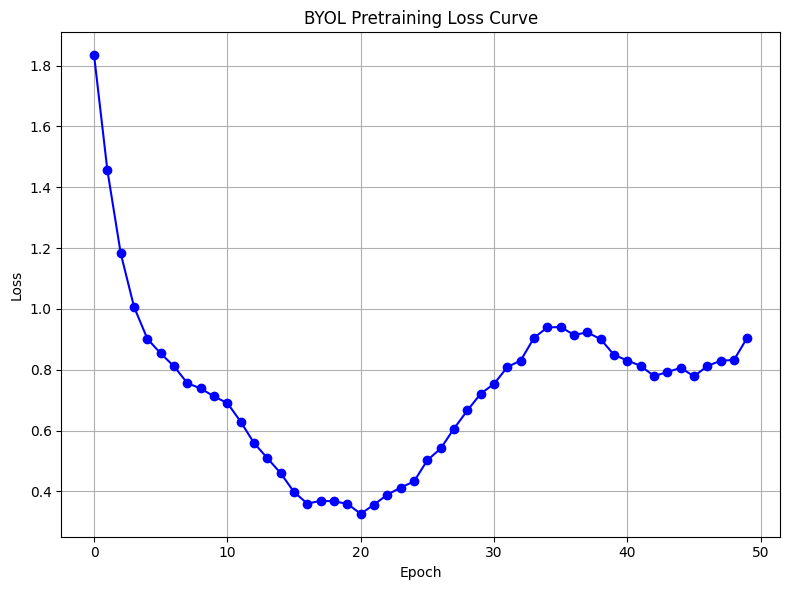

In [14]:
# Plot Loss Curve
# ========================
plt.figure(figsize=(8, 6))
plt.plot(train_losses, marker='o', color='blue')
plt.title("BYOL Pretraining Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.savefig("byol_pretrain_loss_curve.png", dpi=200)
plt.show()

In [19]:
# Prepare BYOL dataset and dataloader
base_unlabeled_dataset = UnlabeledImageDataset(unlabeled_root)
byol_dataset = BYOLPairDataset(base_unlabeled_dataset, augment_fn=augment)
byol_loader = DataLoader(byol_dataset, batch_size=64, shuffle=True)

# Initialize BYOL model
resnet = models.resnet50(pretrained=False)
resnet.fc = nn.Identity()
byol_model = BYOL(resnet).to(device)
optimizer = torch.optim.Adam(byol_model.parameters(), lr=3e-4)

# Training configuration
num_epochs = 50  # set to 1 for testing
train_losses = []

# Pretraining loop
for epoch in range(num_epochs):
    byol_model.train()
    total_loss = 0

    for x1, x2 in tqdm(byol_loader, desc=f"Pretraining Epoch {epoch+1}"):
        x1, x2 = x1.to(device), x2.to(device)
        q1, k1, q2, k2 = byol_model(x1, x2)

        loss = byol_loss(q1, k1) + byol_loss(q2, k2)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        byol_model.update_target()

        total_loss += loss.item()

    avg_loss = total_loss / len(byol_loader)
    train_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {avg_loss:.4f}")


Fine-tune Epoch 1: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s, loss=1.29] 


Epoch 1: | 69/69 [done], Train Loss: 0.8165
Validation Accuracy: 0.5476


Fine-tune Epoch 2: 100%|██████████| 69/69 [00:27<00:00,  2.51it/s, loss=1.42] 


Epoch 2: | 69/69 [done], Train Loss: 0.5071
Validation Accuracy: 0.7656


Fine-tune Epoch 3: 100%|██████████| 69/69 [00:27<00:00,  2.52it/s, loss=0.53] 


Epoch 3: | 69/69 [done], Train Loss: 0.3834
Validation Accuracy: 0.7106


Fine-tune Epoch 4: 100%|██████████| 69/69 [00:27<00:00,  2.51it/s, loss=0.59] 


Epoch 4: | 69/69 [done], Train Loss: 0.3592
Validation Accuracy: 0.7601


Fine-tune Epoch 5: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s, loss=0.787] 


Epoch 5: | 69/69 [done], Train Loss: 0.2843
Validation Accuracy: 0.8791


Fine-tune Epoch 6: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s, loss=0.0124]


Epoch 6: | 69/69 [done], Train Loss: 0.1887
Validation Accuracy: 0.7344


Fine-tune Epoch 7: 100%|██████████| 69/69 [00:27<00:00,  2.51it/s, loss=0.468] 


Epoch 7: | 69/69 [done], Train Loss: 0.1803
Validation Accuracy: 0.7894


Fine-tune Epoch 8: 100%|██████████| 69/69 [00:27<00:00,  2.51it/s, loss=0.0146]


Epoch 8: | 69/69 [done], Train Loss: 0.1813
Validation Accuracy: 0.8278


Fine-tune Epoch 9: 100%|██████████| 69/69 [00:27<00:00,  2.51it/s, loss=1.14]  


Epoch 9: | 69/69 [done], Train Loss: 0.1495
Validation Accuracy: 0.9139


Fine-tune Epoch 10: 100%|██████████| 69/69 [00:27<00:00,  2.52it/s, loss=0.00698]


Epoch 10: | 69/69 [done], Train Loss: 0.1577
Validation Accuracy: 0.9084


Fine-tune Epoch 11: 100%|██████████| 69/69 [00:27<00:00,  2.53it/s, loss=0.361]  


Epoch 11: | 69/69 [done], Train Loss: 0.1133
Validation Accuracy: 0.8663


Fine-tune Epoch 12: 100%|██████████| 69/69 [00:27<00:00,  2.52it/s, loss=0.136]  


Epoch 12: | 69/69 [done], Train Loss: 0.1263
Validation Accuracy: 0.8736


Fine-tune Epoch 13: 100%|██████████| 69/69 [00:27<00:00,  2.53it/s, loss=0.00181]


Epoch 13: | 69/69 [done], Train Loss: 0.0758
Validation Accuracy: 0.9194


Fine-tune Epoch 14: 100%|██████████| 69/69 [00:27<00:00,  2.52it/s, loss=0.0496] 


Epoch 14: | 69/69 [done], Train Loss: 0.0427
Validation Accuracy: 0.8736


Fine-tune Epoch 15: 100%|██████████| 69/69 [00:27<00:00,  2.52it/s, loss=2.23]   


Epoch 15: | 69/69 [done], Train Loss: 0.1320
Validation Accuracy: 0.7857


Fine-tune Epoch 16: 100%|██████████| 69/69 [00:27<00:00,  2.52it/s, loss=1.47]  


Epoch 16: | 69/69 [done], Train Loss: 0.1769
Validation Accuracy: 0.8974


Fine-tune Epoch 17: 100%|██████████| 69/69 [00:27<00:00,  2.54it/s, loss=0.392]  


Epoch 17: | 69/69 [done], Train Loss: 0.1136
Validation Accuracy: 0.9524


Fine-tune Epoch 18: 100%|██████████| 69/69 [00:27<00:00,  2.54it/s, loss=0.301]  


Epoch 18: | 69/69 [done], Train Loss: 0.0723
Validation Accuracy: 0.8443


Fine-tune Epoch 19: 100%|██████████| 69/69 [00:27<00:00,  2.54it/s, loss=0.0297] 


Epoch 19: | 69/69 [done], Train Loss: 0.1419
Validation Accuracy: 0.9359


Fine-tune Epoch 20: 100%|██████████| 69/69 [00:27<00:00,  2.51it/s, loss=2]      


Epoch 20: | 69/69 [done], Train Loss: 0.0656
Validation Accuracy: 0.9139


Fine-tune Epoch 21: 100%|██████████| 69/69 [00:27<00:00,  2.54it/s, loss=0.0584] 


Epoch 21: | 69/69 [done], Train Loss: 0.0915
Validation Accuracy: 0.9469


Fine-tune Epoch 22: 100%|██████████| 69/69 [00:27<00:00,  2.53it/s, loss=0.00559]


Epoch 22: | 69/69 [done], Train Loss: 0.0340
Validation Accuracy: 0.9505


Fine-tune Epoch 23: 100%|██████████| 69/69 [00:27<00:00,  2.54it/s, loss=0.00302] 


Epoch 23: | 69/69 [done], Train Loss: 0.0211
Validation Accuracy: 0.9615


Fine-tune Epoch 24: 100%|██████████| 69/69 [00:27<00:00,  2.53it/s, loss=0.0118]  


Epoch 24: | 69/69 [done], Train Loss: 0.0154
Validation Accuracy: 0.9579


Fine-tune Epoch 25: 100%|██████████| 69/69 [00:27<00:00,  2.54it/s, loss=0.95]    


Epoch 25: | 69/69 [done], Train Loss: 0.0236
Validation Accuracy: 0.9267


Fine-tune Epoch 26: 100%|██████████| 69/69 [00:27<00:00,  2.53it/s, loss=0.0928] 


Epoch 26: | 69/69 [done], Train Loss: 0.1054
Validation Accuracy: 0.9414


Fine-tune Epoch 27: 100%|██████████| 69/69 [00:27<00:00,  2.52it/s, loss=0.042]  


Epoch 27: | 69/69 [done], Train Loss: 0.0308
Validation Accuracy: 0.9377


Fine-tune Epoch 28: 100%|██████████| 69/69 [00:27<00:00,  2.53it/s, loss=3.2]     


Epoch 28: | 69/69 [done], Train Loss: 0.0728
Validation Accuracy: 0.9341


Fine-tune Epoch 29: 100%|██████████| 69/69 [00:27<00:00,  2.54it/s, loss=0.12]  


Epoch 29: | 69/69 [done], Train Loss: 0.2485
Validation Accuracy: 0.9451


Fine-tune Epoch 30: 100%|██████████| 69/69 [00:27<00:00,  2.52it/s, loss=2.37]   


Epoch 30: | 69/69 [done], Train Loss: 0.1081
Validation Accuracy: 0.9267


Fine-tune Epoch 31: 100%|██████████| 69/69 [00:27<00:00,  2.52it/s, loss=0.0188]


Epoch 31: | 69/69 [done], Train Loss: 0.0986
Validation Accuracy: 0.9341


Fine-tune Epoch 32: 100%|██████████| 69/69 [00:27<00:00,  2.53it/s, loss=0.0254] 


Epoch 32: | 69/69 [done], Train Loss: 0.0376
Validation Accuracy: 0.9322


Fine-tune Epoch 33: 100%|██████████| 69/69 [00:27<00:00,  2.55it/s, loss=0.0019] 


Epoch 33: | 69/69 [done], Train Loss: 0.0160
Validation Accuracy: 0.9597


Fine-tune Epoch 34: 100%|██████████| 69/69 [00:27<00:00,  2.53it/s, loss=0.00168] 


Epoch 34: | 69/69 [done], Train Loss: 0.0098
Validation Accuracy: 0.9689


Fine-tune Epoch 35: 100%|██████████| 69/69 [00:27<00:00,  2.54it/s, loss=0.00115] 


Epoch 35: | 69/69 [done], Train Loss: 0.0097
Validation Accuracy: 0.9597


Fine-tune Epoch 36: 100%|██████████| 69/69 [00:27<00:00,  2.52it/s, loss=0.248]   


Epoch 36: | 69/69 [done], Train Loss: 0.0095
Validation Accuracy: 0.9103


Fine-tune Epoch 37: 100%|██████████| 69/69 [00:27<00:00,  2.53it/s, loss=0.00485] 


Epoch 37: | 69/69 [done], Train Loss: 0.0193
Validation Accuracy: 0.9579


Fine-tune Epoch 38: 100%|██████████| 69/69 [00:27<00:00,  2.53it/s, loss=0.00588] 


Epoch 38: | 69/69 [done], Train Loss: 0.0219
Validation Accuracy: 0.9542


Fine-tune Epoch 39: 100%|██████████| 69/69 [00:27<00:00,  2.51it/s, loss=0.000259]


Epoch 39: | 69/69 [done], Train Loss: 0.0154
Validation Accuracy: 0.9560


Fine-tune Epoch 40: 100%|██████████| 69/69 [00:27<00:00,  2.53it/s, loss=0.00495] 


Epoch 40: | 69/69 [done], Train Loss: 0.0055
Validation Accuracy: 0.9542


Fine-tune Epoch 41: 100%|██████████| 69/69 [00:27<00:00,  2.52it/s, loss=0.00766] 


Epoch 41: | 69/69 [done], Train Loss: 0.0111
Validation Accuracy: 0.9634


Fine-tune Epoch 42: 100%|██████████| 69/69 [00:27<00:00,  2.54it/s, loss=0.0186]  


Epoch 42: | 69/69 [done], Train Loss: 0.0053
Validation Accuracy: 0.9542


Fine-tune Epoch 43: 100%|██████████| 69/69 [00:27<00:00,  2.52it/s, loss=0.00394] 


Epoch 43: | 69/69 [done], Train Loss: 0.0125
Validation Accuracy: 0.9359


Fine-tune Epoch 44: 100%|██████████| 69/69 [00:27<00:00,  2.52it/s, loss=0.856]   


Epoch 44: | 69/69 [done], Train Loss: 0.0388
Validation Accuracy: 0.9084


Fine-tune Epoch 45: 100%|██████████| 69/69 [00:27<00:00,  2.53it/s, loss=1.66]   


Epoch 45: | 69/69 [done], Train Loss: 0.1915
Validation Accuracy: 0.8718


Fine-tune Epoch 46: 100%|██████████| 69/69 [00:27<00:00,  2.54it/s, loss=1.05]  


Epoch 46: | 69/69 [done], Train Loss: 0.1904
Validation Accuracy: 0.8864


Fine-tune Epoch 47: 100%|██████████| 69/69 [00:27<00:00,  2.53it/s, loss=0.0819] 


Epoch 47: | 69/69 [done], Train Loss: 0.0989
Validation Accuracy: 0.9066


Fine-tune Epoch 48: 100%|██████████| 69/69 [00:27<00:00,  2.52it/s, loss=0.072]  


Epoch 48: | 69/69 [done], Train Loss: 0.0479
Validation Accuracy: 0.9505


Fine-tune Epoch 49: 100%|██████████| 69/69 [00:27<00:00,  2.53it/s, loss=0.0131]  


Epoch 49: | 69/69 [done], Train Loss: 0.0325
Validation Accuracy: 0.9542


Fine-tune Epoch 50: 100%|██████████| 69/69 [00:27<00:00,  2.52it/s, loss=3.25]    


Epoch 50: | 69/69 [done], Train Loss: 0.0668
Validation Accuracy: 0.9487


In [25]:
import os
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

# -----------------------------
# Configuration
# -----------------------------
data_dir = "/kaggle/input/leafdetection7/Niphad Grape Leaf Disease Dataset (NGLD) (2)/lebel/Niphad Grape Leaf Disease Dataset (NGLD)/Grapes Disease Dataset"
pretrained_path = "/kaggle/working/byol_encoder.pth"
num_epochs = 50
batch_size = 32
lr = 1e-4
image_size = 224
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------
# Transforms & Dataset
# -----------------------------
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

full_dataset = torchvision.datasets.ImageFolder(root=data_dir, transform=transform)
class_names = full_dataset.classes
num_classes = len(class_names)

# Train-val split
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# -----------------------------
# BYOL ResNet Encoder
# -----------------------------
class BYOLResNet50(nn.Module):
    def __init__(self, pretrained_path):
        super(BYOLResNet50, self).__init__()
        resnet = torchvision.models.resnet50(pretrained=False)
        resnet.fc = nn.Identity()
        self.backbone = resnet
        state_dict = torch.load(pretrained_path, map_location='cpu')
        self.backbone.load_state_dict(state_dict, strict=False)

    def forward(self, x):
        return self.backbone(x)

# -----------------------------
# Fine-Tuning Model
# -----------------------------
class FineTuneBYOL(nn.Module):
    def __init__(self, encoder, num_classes):
        super(FineTuneBYOL, self).__init__()
        self.encoder = encoder
        self.classifier = nn.Linear(2048, num_classes)

    def forward(self, x):
        x = self.encoder(x)
        return self.classifier(x)

# Instantiate model
encoder = BYOLResNet50(pretrained_path)
model = FineTuneBYOL(encoder, num_classes).to(device)

# -----------------------------
# Training Setup
# -----------------------------
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# -----------------------------
# Training Loop
# -----------------------------
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct_train = 0
    total_train = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)
        loop.set_postfix(loss=loss.item())

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_acc = correct_train / total_train
    train_accuracies.append(train_acc)

    # -------------------------
    # Validation
    # -------------------------
    model.eval()
    correct_val = 0
    total_val = 0
    val_loss = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_acc = correct_val / total_val
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}")



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Epoch 1/50: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s, loss=1.52] 


Epoch 1: Train Loss: 0.8030, Train Acc: 0.6794, Val Loss: 0.6589, Val Acc: 0.7821


Epoch 2/50: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s, loss=1.27] 


Epoch 2: Train Loss: 0.4661, Train Acc: 0.8252, Val Loss: 0.6797, Val Acc: 0.7491


Epoch 3/50: 100%|██████████| 69/69 [00:27<00:00,  2.52it/s, loss=0.276] 


Epoch 3: Train Loss: 0.3687, Train Acc: 0.8651, Val Loss: 0.7182, Val Acc: 0.8040


Epoch 4/50: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s, loss=0.033] 


Epoch 4: Train Loss: 0.2890, Train Acc: 0.8991, Val Loss: 1.6382, Val Acc: 0.6117


Epoch 5/50: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s, loss=0.575] 


Epoch 5: Train Loss: 0.2550, Train Acc: 0.9083, Val Loss: 1.0033, Val Acc: 0.7601


Epoch 6/50: 100%|██████████| 69/69 [00:27<00:00,  2.52it/s, loss=0.627] 


Epoch 6: Train Loss: 0.3002, Train Acc: 0.9018, Val Loss: 0.3210, Val Acc: 0.8974


Epoch 7/50: 100%|██████████| 69/69 [00:27<00:00,  2.51it/s, loss=0.112] 


Epoch 7: Train Loss: 0.1893, Train Acc: 0.9381, Val Loss: 0.2035, Val Acc: 0.9432


Epoch 8/50: 100%|██████████| 69/69 [00:27<00:00,  2.52it/s, loss=0.141] 


Epoch 8: Train Loss: 0.1131, Train Acc: 0.9665, Val Loss: 0.4071, Val Acc: 0.8571


Epoch 9/50: 100%|██████████| 69/69 [00:27<00:00,  2.51it/s, loss=0.465]  


Epoch 9: Train Loss: 0.1122, Train Acc: 0.9656, Val Loss: 0.3787, Val Acc: 0.8828


Epoch 10/50: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s, loss=2.32]  


Epoch 10: Train Loss: 0.1804, Train Acc: 0.9500, Val Loss: 2.0834, Val Acc: 0.6245


Epoch 11/50: 100%|██████████| 69/69 [00:27<00:00,  2.50it/s, loss=0.234] 


Epoch 11: Train Loss: 0.1950, Train Acc: 0.9330, Val Loss: 0.6447, Val Acc: 0.8150


Epoch 12/50: 100%|██████████| 69/69 [00:27<00:00,  2.51it/s, loss=0.155] 


Epoch 12: Train Loss: 0.1348, Train Acc: 0.9550, Val Loss: 0.2954, Val Acc: 0.8956


Epoch 13/50: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s, loss=0.0016] 


Epoch 13: Train Loss: 0.0778, Train Acc: 0.9757, Val Loss: 0.4171, Val Acc: 0.8755


Epoch 14/50: 100%|██████████| 69/69 [00:27<00:00,  2.51it/s, loss=0.00157]


Epoch 14: Train Loss: 0.0702, Train Acc: 0.9821, Val Loss: 0.1698, Val Acc: 0.9524


Epoch 15/50: 100%|██████████| 69/69 [00:27<00:00,  2.52it/s, loss=0.789]  


Epoch 15: Train Loss: 0.0770, Train Acc: 0.9757, Val Loss: 1.4871, Val Acc: 0.7747


Epoch 16/50: 100%|██████████| 69/69 [00:27<00:00,  2.52it/s, loss=0.0792]


Epoch 16: Train Loss: 0.2220, Train Acc: 0.9211, Val Loss: 0.9399, Val Acc: 0.7088


Epoch 17/50: 100%|██████████| 69/69 [00:27<00:00,  2.51it/s, loss=1.21]  


Epoch 17: Train Loss: 0.1831, Train Acc: 0.9385, Val Loss: 0.3224, Val Acc: 0.9011


Epoch 18/50: 100%|██████████| 69/69 [00:27<00:00,  2.51it/s, loss=0.822] 


Epoch 18: Train Loss: 0.1051, Train Acc: 0.9729, Val Loss: 0.2813, Val Acc: 0.8993


Epoch 19/50: 100%|██████████| 69/69 [00:27<00:00,  2.51it/s, loss=0.166] 


Epoch 19: Train Loss: 0.1393, Train Acc: 0.9482, Val Loss: 0.2892, Val Acc: 0.9231


Epoch 20/50: 100%|██████████| 69/69 [00:27<00:00,  2.51it/s, loss=0.0474] 


Epoch 20: Train Loss: 0.0930, Train Acc: 0.9716, Val Loss: 0.1786, Val Acc: 0.9396


Epoch 21/50: 100%|██████████| 69/69 [00:27<00:00,  2.51it/s, loss=0.483]  


Epoch 21: Train Loss: 0.0605, Train Acc: 0.9830, Val Loss: 0.1783, Val Acc: 0.9615


Epoch 22/50: 100%|██████████| 69/69 [00:27<00:00,  2.50it/s, loss=1.04]   


Epoch 22: Train Loss: 0.0735, Train Acc: 0.9775, Val Loss: 0.2812, Val Acc: 0.9231


Epoch 23/50: 100%|██████████| 69/69 [00:27<00:00,  2.52it/s, loss=0.0335] 


Epoch 23: Train Loss: 0.0813, Train Acc: 0.9693, Val Loss: 0.2768, Val Acc: 0.9286


Epoch 24/50: 100%|██████████| 69/69 [00:27<00:00,  2.51it/s, loss=0.0377] 


Epoch 24: Train Loss: 0.0555, Train Acc: 0.9839, Val Loss: 0.2572, Val Acc: 0.9359


Epoch 25/50: 100%|██████████| 69/69 [00:27<00:00,  2.52it/s, loss=0.262]   


Epoch 25: Train Loss: 0.0358, Train Acc: 0.9904, Val Loss: 0.1376, Val Acc: 0.9615


Epoch 26/50: 100%|██████████| 69/69 [00:27<00:00,  2.51it/s, loss=0.315]   


Epoch 26: Train Loss: 0.0305, Train Acc: 0.9904, Val Loss: 0.1954, Val Acc: 0.9469


Epoch 27/50: 100%|██████████| 69/69 [00:27<00:00,  2.53it/s, loss=5.26]   


Epoch 27: Train Loss: 0.1783, Train Acc: 0.9693, Val Loss: 0.1697, Val Acc: 0.9560


Epoch 28/50: 100%|██████████| 69/69 [00:27<00:00,  2.52it/s, loss=0.00835]


Epoch 28: Train Loss: 0.1217, Train Acc: 0.9596, Val Loss: 0.1063, Val Acc: 0.9707


Epoch 29/50: 100%|██████████| 69/69 [00:27<00:00,  2.51it/s, loss=0.971]  


Epoch 29: Train Loss: 0.0415, Train Acc: 0.9908, Val Loss: 0.1374, Val Acc: 0.9560


Epoch 30/50: 100%|██████████| 69/69 [00:27<00:00,  2.53it/s, loss=0.011]  


Epoch 30: Train Loss: 0.0801, Train Acc: 0.9757, Val Loss: 0.1450, Val Acc: 0.9615


Epoch 31/50: 100%|██████████| 69/69 [00:27<00:00,  2.52it/s, loss=0.421]   


Epoch 31: Train Loss: 0.0331, Train Acc: 0.9908, Val Loss: 0.5345, Val Acc: 0.8810


Epoch 32/50: 100%|██████████| 69/69 [00:27<00:00,  2.50it/s, loss=0.171]  


Epoch 32: Train Loss: 0.0594, Train Acc: 0.9803, Val Loss: 0.1838, Val Acc: 0.9359


Epoch 33/50: 100%|██████████| 69/69 [00:27<00:00,  2.50it/s, loss=0.00295]


Epoch 33: Train Loss: 0.0394, Train Acc: 0.9862, Val Loss: 0.1598, Val Acc: 0.9451


Epoch 34/50: 100%|██████████| 69/69 [00:27<00:00,  2.50it/s, loss=0.421]   


Epoch 34: Train Loss: 0.0173, Train Acc: 0.9968, Val Loss: 0.1039, Val Acc: 0.9652


Epoch 35/50: 100%|██████████| 69/69 [00:27<00:00,  2.50it/s, loss=0.000961]


Epoch 35: Train Loss: 0.0258, Train Acc: 0.9904, Val Loss: 0.1459, Val Acc: 0.9670


Epoch 36/50: 100%|██████████| 69/69 [00:27<00:00,  2.50it/s, loss=0.0116]  


Epoch 36: Train Loss: 0.0059, Train Acc: 0.9986, Val Loss: 0.1124, Val Acc: 0.9689


Epoch 37/50: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s, loss=0.177]   


Epoch 37: Train Loss: 0.0096, Train Acc: 0.9982, Val Loss: 0.1195, Val Acc: 0.9689


Epoch 38/50: 100%|██████████| 69/69 [00:27<00:00,  2.52it/s, loss=0.2]     


Epoch 38: Train Loss: 0.0385, Train Acc: 0.9885, Val Loss: 0.3836, Val Acc: 0.9139


Epoch 39/50: 100%|██████████| 69/69 [00:27<00:00,  2.50it/s, loss=0.023]  


Epoch 39: Train Loss: 0.0590, Train Acc: 0.9821, Val Loss: 0.1967, Val Acc: 0.9560


Epoch 40/50: 100%|██████████| 69/69 [00:27<00:00,  2.52it/s, loss=1.02]    


Epoch 40: Train Loss: 0.0249, Train Acc: 0.9982, Val Loss: 0.1409, Val Acc: 0.9560


Epoch 41/50: 100%|██████████| 69/69 [00:27<00:00,  2.51it/s, loss=0.314]  


Epoch 41: Train Loss: 0.1049, Train Acc: 0.9665, Val Loss: 0.3760, Val Acc: 0.9029


Epoch 42/50: 100%|██████████| 69/69 [00:27<00:00,  2.52it/s, loss=1.06]   


Epoch 42: Train Loss: 0.0699, Train Acc: 0.9789, Val Loss: 0.2676, Val Acc: 0.9286


Epoch 43/50: 100%|██████████| 69/69 [00:27<00:00,  2.50it/s, loss=2.03]   


Epoch 43: Train Loss: 0.1223, Train Acc: 0.9679, Val Loss: 0.2229, Val Acc: 0.9249


Epoch 44/50: 100%|██████████| 69/69 [00:27<00:00,  2.52it/s, loss=0.398]  


Epoch 44: Train Loss: 0.0604, Train Acc: 0.9784, Val Loss: 0.1597, Val Acc: 0.9542


Epoch 45/50: 100%|██████████| 69/69 [00:27<00:00,  2.51it/s, loss=1.25]   


Epoch 45: Train Loss: 0.0549, Train Acc: 0.9876, Val Loss: 0.1452, Val Acc: 0.9615


Epoch 46/50: 100%|██████████| 69/69 [00:27<00:00,  2.51it/s, loss=0.304]  


Epoch 46: Train Loss: 0.0709, Train Acc: 0.9757, Val Loss: 0.1895, Val Acc: 0.9524


Epoch 47/50: 100%|██████████| 69/69 [00:27<00:00,  2.51it/s, loss=0.0413]  


Epoch 47: Train Loss: 0.0393, Train Acc: 0.9849, Val Loss: 0.1907, Val Acc: 0.9505


Epoch 48/50: 100%|██████████| 69/69 [00:27<00:00,  2.52it/s, loss=0.00933] 


Epoch 48: Train Loss: 0.0265, Train Acc: 0.9899, Val Loss: 0.2181, Val Acc: 0.9341


Epoch 49/50: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s, loss=0.113]   


Epoch 49: Train Loss: 0.0102, Train Acc: 0.9972, Val Loss: 0.1534, Val Acc: 0.9615


Epoch 50/50: 100%|██████████| 69/69 [00:27<00:00,  2.47it/s, loss=0.00371] 


Epoch 50: Train Loss: 0.0159, Train Acc: 0.9940, Val Loss: 0.1117, Val Acc: 0.9652


In [26]:
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Train Accuracy: {train_acc:.4f}")

Validation Accuracy: 0.9652
Train Accuracy: 0.9940


In [29]:
# Save the full model state dict
model_path = "/kaggle/working/fine_tuned_model.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")


Model saved to /kaggle/working/fine_tuned_model.pth


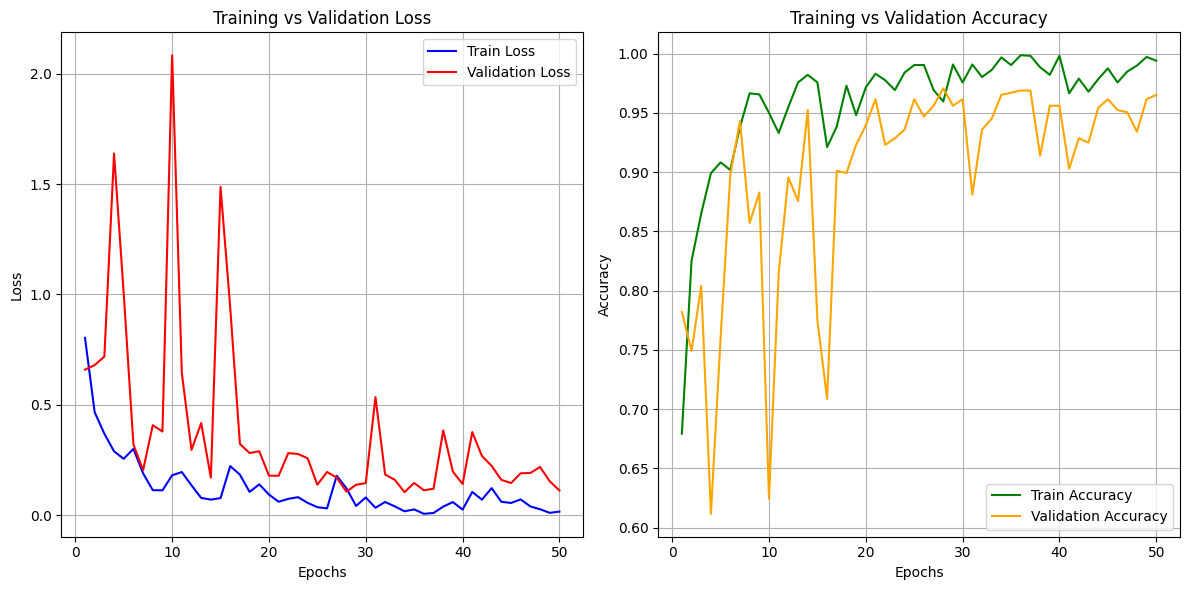

In [30]:
# -----------------------------
# Plotting Curves
# -----------------------------
def plot_loss_accuracy(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 6))

    # Loss Curve
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss', color='blue')
    plt.plot(epochs, val_losses, label='Validation Loss', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.grid(True)

    # Accuracy Curve
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy', color='green')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig("loss_accuracy_curves.png", dpi=300)  # Optional: save figure
    plt.show()

# Plot curves
plot_loss_accuracy(train_losses, val_losses, train_accuracies, val_accuracies)


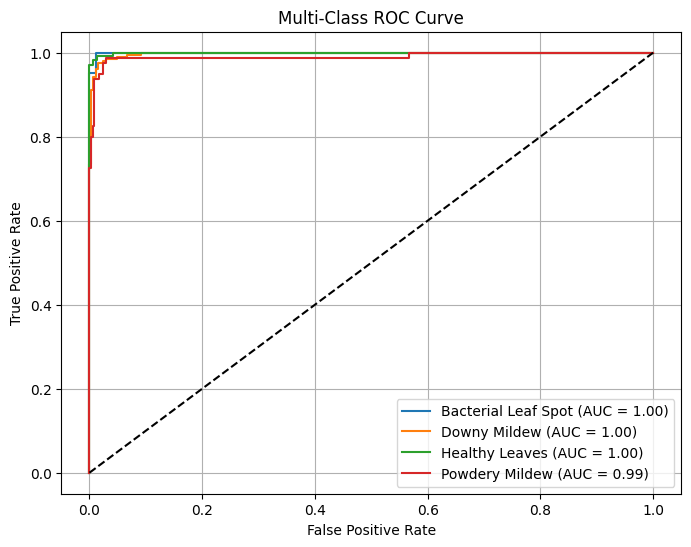

In [31]:

# ROC-AUC Curve
# -----------------------------
model.eval()
all_preds = []
all_probs = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        all_probs.extend(probs.cpu().numpy())
        all_preds.extend(torch.argmax(probs, dim=1).cpu().numpy())
        all_labels.extend(labels.numpy())

# One-hot encode ground truth
y_true = label_binarize(all_labels, classes=list(range(num_classes)))
y_score = np.array(all_probs)

# Plot ROC
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-Class ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


Classification Report:

                     precision    recall  f1-score   support

Bacterial Leaf Spot       0.91      0.95      0.93        21
       Downy Mildew       0.96      0.98      0.97       204
     Healthy Leaves       0.98      0.98      0.98       241
     Powdery Mildew       0.95      0.89      0.92        80

           accuracy                           0.97       546
          macro avg       0.95      0.95      0.95       546
       weighted avg       0.97      0.97      0.96       546


Overall Accuracy: 0.97


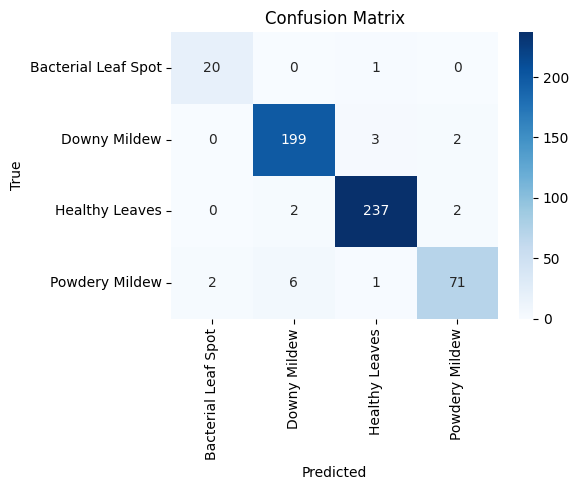

In [32]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Evaluation on validation set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Classification Report
print("Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=class_names, digits=2))

# Accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"\nOverall Accuracy: {accuracy:.2f}")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)



✅ Test Accuracy: 98.29%

📊 Classification Report:

                     precision    recall  f1-score   support

Bacterial Leaf Spot       0.94      1.00      0.97        15
       Downy Mildew       0.97      0.99      0.98       145
     Healthy Leaves       1.00      0.99      1.00       188
     Powdery Mildew       0.97      0.92      0.94        61

           accuracy                           0.98       409
          macro avg       0.97      0.98      0.97       409
       weighted avg       0.98      0.98      0.98       409



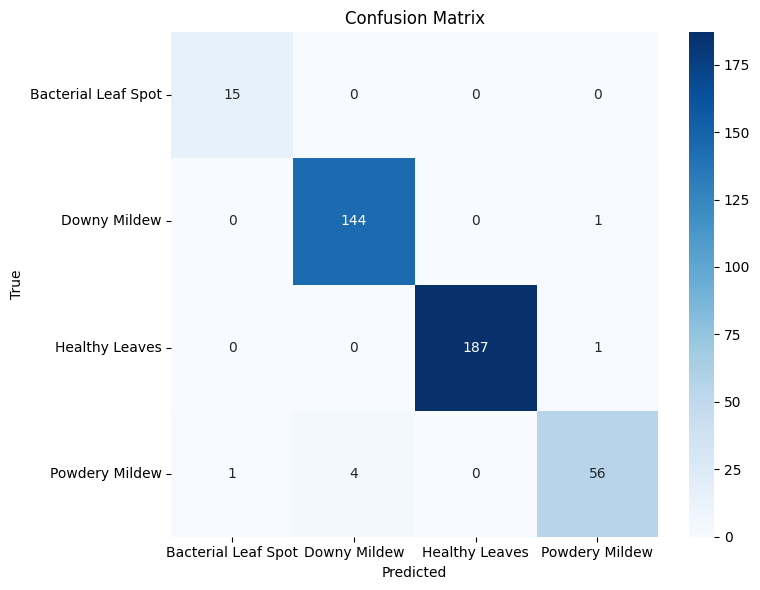

In [47]:
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Paths
test_dir = "/kaggle/input/testdata444/Niphad Grape Leaf Disease Dataset (NGLD)/Grapes Disease Dataset test"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transforms
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Dataset & Loader
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
class_names = test_dataset.classes

# Load model
encoder = BYOLResNet50(pretrained_path)  # your BYOL-pretrained encoder
model = FineTuneBYOL(encoder, num_classes=len(class_names)).to(device)
model.load_state_dict(torch.load("/kaggle/working/fine_tuned_model.pth", map_location=device))
model.eval()

# Predict
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = torch.argmax(F.softmax(outputs, dim=1), dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"\n✅ Test Accuracy: {accuracy * 100:.2f}%")

# Classification Report
print("\n📊 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()
